# H&M Recommendation System

This notebook has turned into an amalgamation of i.) trying to upload the H&M transactions data to an S3 bucket so that I can use PySpark in DataBricks to handle the large volume of data (*top*) and ii.) my original attempt to build a proof of concept recommendation system for H&M using transactions data stored in a numpy array (*bottom*.)

In this section, I connect to my S3 bucket for this project's data: h-and-m.

In [1]:
import boto3

In [4]:
s3 = boto3.client('s3')

In [5]:
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  h-and-m


Here, I tried to upload the zipped H&M data in this directory in its entirety to my S3 bucket. The process took hours and then seemed to time out without uploading the file.

In [10]:
filename='data/h-and-m-personalized-fashion-recommendations.zip'

s3.upload_file(
    filename, 'h-and-m', 'h-and-m-data'
)

ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "https://h-and-m.s3.us-east-2.amazonaws.com/h-and-m-data?uploadId=W79VT8TxeH.TkpwnCgagoJysLfuEx2XECddK8U2AqKSERieWxJjeNZFfiGgFjjHjVwiKiMQl6ry3h7f2_8tGJce9P0COCaQzXLT8_glBXNYZDkcSZYZ6FsMw6eOBf.Ps&partNumber=858".

As a work-around, I decided to load the transactions data into a Pandas dataframe (which takes a long-ish time, but still less than a minute) and then split it into packets which can be uploaded separately to the S3 bucket through the AWS console. This is not ideal, but it's better than being stuck for days trying to understand how the AWS connection works, data upload speeds, etc.

I'm going to copy some of the code from below in my original project proof of concept here, so that I can keep all of my work for uploading the data to an S3 bucket in one place.

In [25]:
# imports
from zipfile import ZipFile
import pandas as pd
import numpy as np

In [ ]:
%%time
# load ALL transactions into a Pandas dataframe
with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('transactions_train.csv') as f:
        transactions = pd.read_csv(f)

Split the data into 64 packets, roughly equally sized though it doesn't need to be exact. Save each one to a .csv file in a folder called "packets" within the data directory.

In [21]:
indices = [int(x) for x in np.linspace(0, transactions.shape[0], 64)]

for i in range(len(indices)-1):
    start = indices[i]
    stop = indices[i+1]
    packet = transactions.loc[start:stop, :].copy()
    with open(f"data/packets/transactions{i}.csv", "x") as f:
        packet.to_csv(f)

IndexError: list index out of range

# H&M Recommendation System

This notebook is my proof-of-concept for a recommendation system for H&M to provide personalized recommendations to users while browsing their website.

Data

[Source](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview)

In [11]:
seed = 39

In [12]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Let's load the tabular data on transactions first. This will be the bread and butter of our recommendation system (though we need to address the cold start problem and look at ways of improving beyond simple matrix factorization.) The data is large, so out of curiosity, I am going to time the execution of the cell below which reads in the transaction data as a pandas dataframe.

In [13]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('transactions_train.csv') as f:
        transactions = pd.read_csv(f)

CPU times: user 32 s, sys: 3.67 s, total: 35.6 s
Wall time: 39 s


In [14]:
# how many records and features are in the full transactions file?
print(transactions.shape)

(31788324, 5)


There is no need to use all 31 million + transactions to develop a proof of concept! I am going to take a random sample of 1 million transactions (which is about 3% of the data) to develop a proof of concept model.

In [5]:
transactions_sample = transactions.sample(1000000, random_state=seed).copy()

In [7]:
# save to file, so I don't have to reload entire transactions dataset everytime
with open("data/transactions_sample.csv", "x") as f:
    transactions_sample.to_csv(f)

In [3]:
# test that file is saved
transactions_sample = pd.read_csv('data/transactions_sample.csv', index_col=0)

In [4]:
transactions_sample.head()

,t_dat,customer_id,article_id,price,sales_channel_id
6819188,2019-02-28,cf4254f236a7d3f4d13590ab316524c245113a755786ad...,639192002,0.067780,1
1937255,2018-10-30,9da5d0fc26ed578538293270b501d5d040b85c43b27743...,652361003,0.008458,2
30574525,2020-08-21,52d409edafe2ab3c946d7b6a9bacc1cc6f09fe31a0fa9e...,877273001,0.033881,1
6990198,2019-03-05,7022f60068ed9d8cb9270bdc4cf070d5054b9ba026a450...,714543001,0.012542,1
18501631,2019-11-01,4d4f9a5031d13fdd485d15a0c51b611db30a1a8bd5b45e...,765853019,0.067780,2


Within this sample, we have:

| Number of Unique Customers | Number of Unique Articles |
| --- | --- |
| 486,887 | 71,886 |

In our entire dataset, we have:

| Number of Unique Customers | Number of Unique Articles |
| --- | --- |
| 1,371,980 | 105,542 |

Practically speaking, I don't think it's a problem that we are not representing anywhere close to all customers in the system in our sample.

Having the unique articles represented seems more important to me. Hopefully three quarters of them is enough.

## Visualizations

The code below plots the percentage of transactions accounted for by the first $n$ articles listed by popularity. I plan to use this plot to eyeball a "head" for my items and get a sense of how my recommender may struggle with the long tail problem for this data.

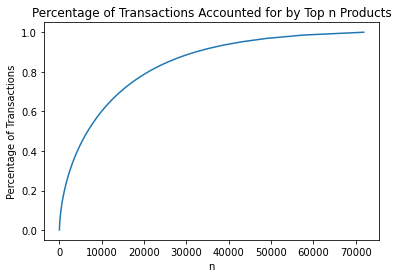

In [5]:
fig, ax = plt.subplots()

plt.plot(range(1, len(transactions_sample.article_id.value_counts()) + 1),
         np.cumsum(transactions_sample.article_id.value_counts(normalize=True)).values)
ax.set(title='Percentage of Transactions Accounted for by Top n Products',
       xlabel = 'n',
       ylabel = 'Percentage of Transactions');

Out of a little over 70,000 unique products in our sample, more than half of transactions involve less than 10,000 of them.

Let's see if we can plot a long tail plot.

In [6]:
# select number of transactions including each article
article_popularity = transactions_sample.article_id.value_counts()

The value counts series above (for the article_id column of transactions_sample) links each article id to the number of times that article was purchased.

| article_id | number of purchases |
| --- | --- |
|  |  |

Below, I reset the index of this series to reference each article by its relative popularity, rather than its unique id.

For example: index 0 refers to the number 1 most popular item, index 1 refers to the second most popular item, etc.

The values in the series still specify how many transactions involved that article. From this series, we can generate our long tail plot.

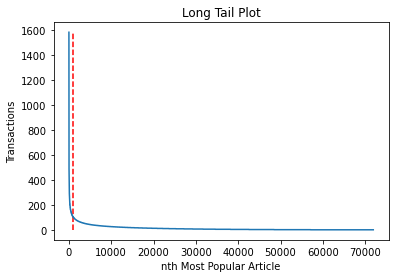

In [7]:
# plot number of transactions versus nth most popular article
fig, ax = plt.subplots()

plt.plot(article_popularity.reset_index().drop(['index'], axis=1))
ax.set(title='Long Tail Plot', xlabel='nth Most Popular Article', ylabel='Transactions')

# highlight the point at which less than 100 transactions include an item
article_no = list(article_popularity.values).index(100)

plt.vlines(x=article_no,
           ymin=0,
           ymax=max(article_popularity.values),
           linestyles='dashed',
           color='r');

Most of our transactions involved articles which were purchased fewer than 100 times. This could be a good thing for training our recommendation system, if most of the items are in the long tail. However, we may want to drop the 1074 most popular items (purchased more than 100 times each) if the system is struggling to provide coverage.

Out of curiosity and practicality, how many items were only purchased once?

---

14,821 items were only purchased once.

1,074 items have been purchased over 100 times.

55,991 items are "in the middle".

This is my first time building a recommendation system, so I want to take a moment to think through how I should structure this project.

- explore metadata on articles & customers
- decide on an evaluation metric
- determine a validation strategy
- decide how to pull the data together: use article_

In [8]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('articles.csv') as f:
        articles = pd.read_csv(f)

CPU times: user 1.01 s, sys: 41.5 ms, total: 1.05 s
Wall time: 1.05 s


In [33]:
articles.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,image
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,None
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.,None


In [34]:
articles.shape

(105542, 26)

In [9]:
%%time

with ZipFile('data/h-and-m-personalized-fashion-recommendations.zip') as zipArchive:
    with zipArchive.open('customers.csv') as f:
        customers = pd.read_csv(f)

CPU times: user 4.04 s, sys: 231 ms, total: 4.28 s
Wall time: 4.4 s


In [12]:
customers.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...


In [45]:
customers.shape

(1371980, 7)

----

I am going to select 800,000 transactions to constitute the training data and 200,000 transactions to make up the hold out test set.

Then, I am going to further subdivide the training data into true training and validation data with a 75% / 25% split.

In [10]:
# get training data (including validation)
train = transactions_sample.sample(800000, random_state=seed).copy()
# which indices are "leftover" after selecting training data?
test_indices = list(set(transactions_sample.index) - set(train.index))
# get test data
test = transactions_sample.loc[ test_indices ].copy()

# get validation data
val = train.sample(200000, random_state=seed).copy()
train_indices = list(set(train.index) - set(val.index))

# reset train to NOT include validation data
train = train.loc[ train_indices ].copy()

In [11]:
print(train.shape)
print(val.shape)
print(test.shape)

(600000, 5)
(200000, 5)
(200000, 5)


## Model 1

Building a recommendation system which uses alternating least squares to obtain a PQ factorization of the utility matrix.

### Build Utility Matrix from Customers & Articles in Training Transaction Data

Recall that the utility matrix refers to the user-item ratings matrix.

In our case, we are using implicit ratings = number of times that a customer has bought an article.

Get the unique customers and articles in the training data.

In [12]:
unique_customers = np.unique(train.customer_id)
unique_articles = np.unique(train.article_id)

Label encode the unique customers and articles so that you can index the utility matrix in base numpy. (Only Pandas lets the index and column names be non-integer or non-consecutive integer.)

In [13]:
from sklearn.preprocessing import LabelEncoder

customer_le = LabelEncoder()
article_le = LabelEncoder()

customer_code = customer_le.fit_transform(unique_customers)
article_code = article_le.fit_transform(unique_articles)

Create a matrix of zeros of the appropriate size for the utility matrix.

In [14]:
utility = np.zeros((len(customer_code), len(article_code)))

Grab transaction information from the training data.

In [15]:
train_transactions = train.loc[:, ['customer_id', 'article_id']].copy()

Label encode the customer and article ids in the training data.

In [16]:
train_transactions['customer_id'] = customer_le.transform(train_transactions['customer_id'])
train_transactions['article_id'] = article_le.transform(train_transactions['article_id'])

Iterate over each row representing a transaction in the training data, and add 1 to the appropriate \[user, item\] entry in the utility matrix.

In [17]:
for i, index in enumerate(train_transactions.index):
    code = train_transactions.loc[index, 'customer_id']
    article = train_transactions.loc[index, 'article_id']
    
    utility[code, article] += 1

*To save space, checking the utility matrix has been deleted.*

### Use Alternating Least Squares to Approximate $PQ^T$ Factorization of Utility Matrix

To get a handle on the process, let's start with $k=5$ latent factors, and build the rank 5 $PQ^{T}$ approximation of the utility / ratings matrix.

The idea behind alternating least squares is to "guess" the values of P and Q, then iteratively update these entries according to least squares.

In [28]:
k = 5

users = np.ones((utility.shape[0], k))
items = np.ones((utility.shape[1], k))

In [ ]:
from sklearn.linear_model import LinearRegression

for row in range(utility.shape[0]):
    lr = LinearRegression(fit_intercept=False)
    # rows of items are "records", target is first row of utility matrix
    lr.fit(items, utility[row,:].reshape(-1, 1))

    users[row, :] = lr.coef_[0]

In [ ]:
users

In [ ]:
for col in range(utility.shape[1]):
    lr = LinearRegression(fit_intercept=False)
    
    lr.fit(users, utility[:, col])
    
    items[:, col] = lr.coef_[0]